# 🐝 010_[EDA]Make_Molecule_Visualizer(with wandb) 🐝
---
[目的]
- 化合物名 x 分子構造の可視化 x description(日本語版) をweb APIで表示できるようにして、EDAの効率化を目指す.  

[内容]
- データの前処理（化合物名、descriptionの日本語化. 必要な特徴量を追加)
- データの可視化
- wandbへのアップロード


※ コードはclaude codeに頼って生成いたしました. ありがとうclaude!!

---

[アウトプットイメージ]
- wandb上で以下のように各化合物の描画と特徴を眺められるようになります.

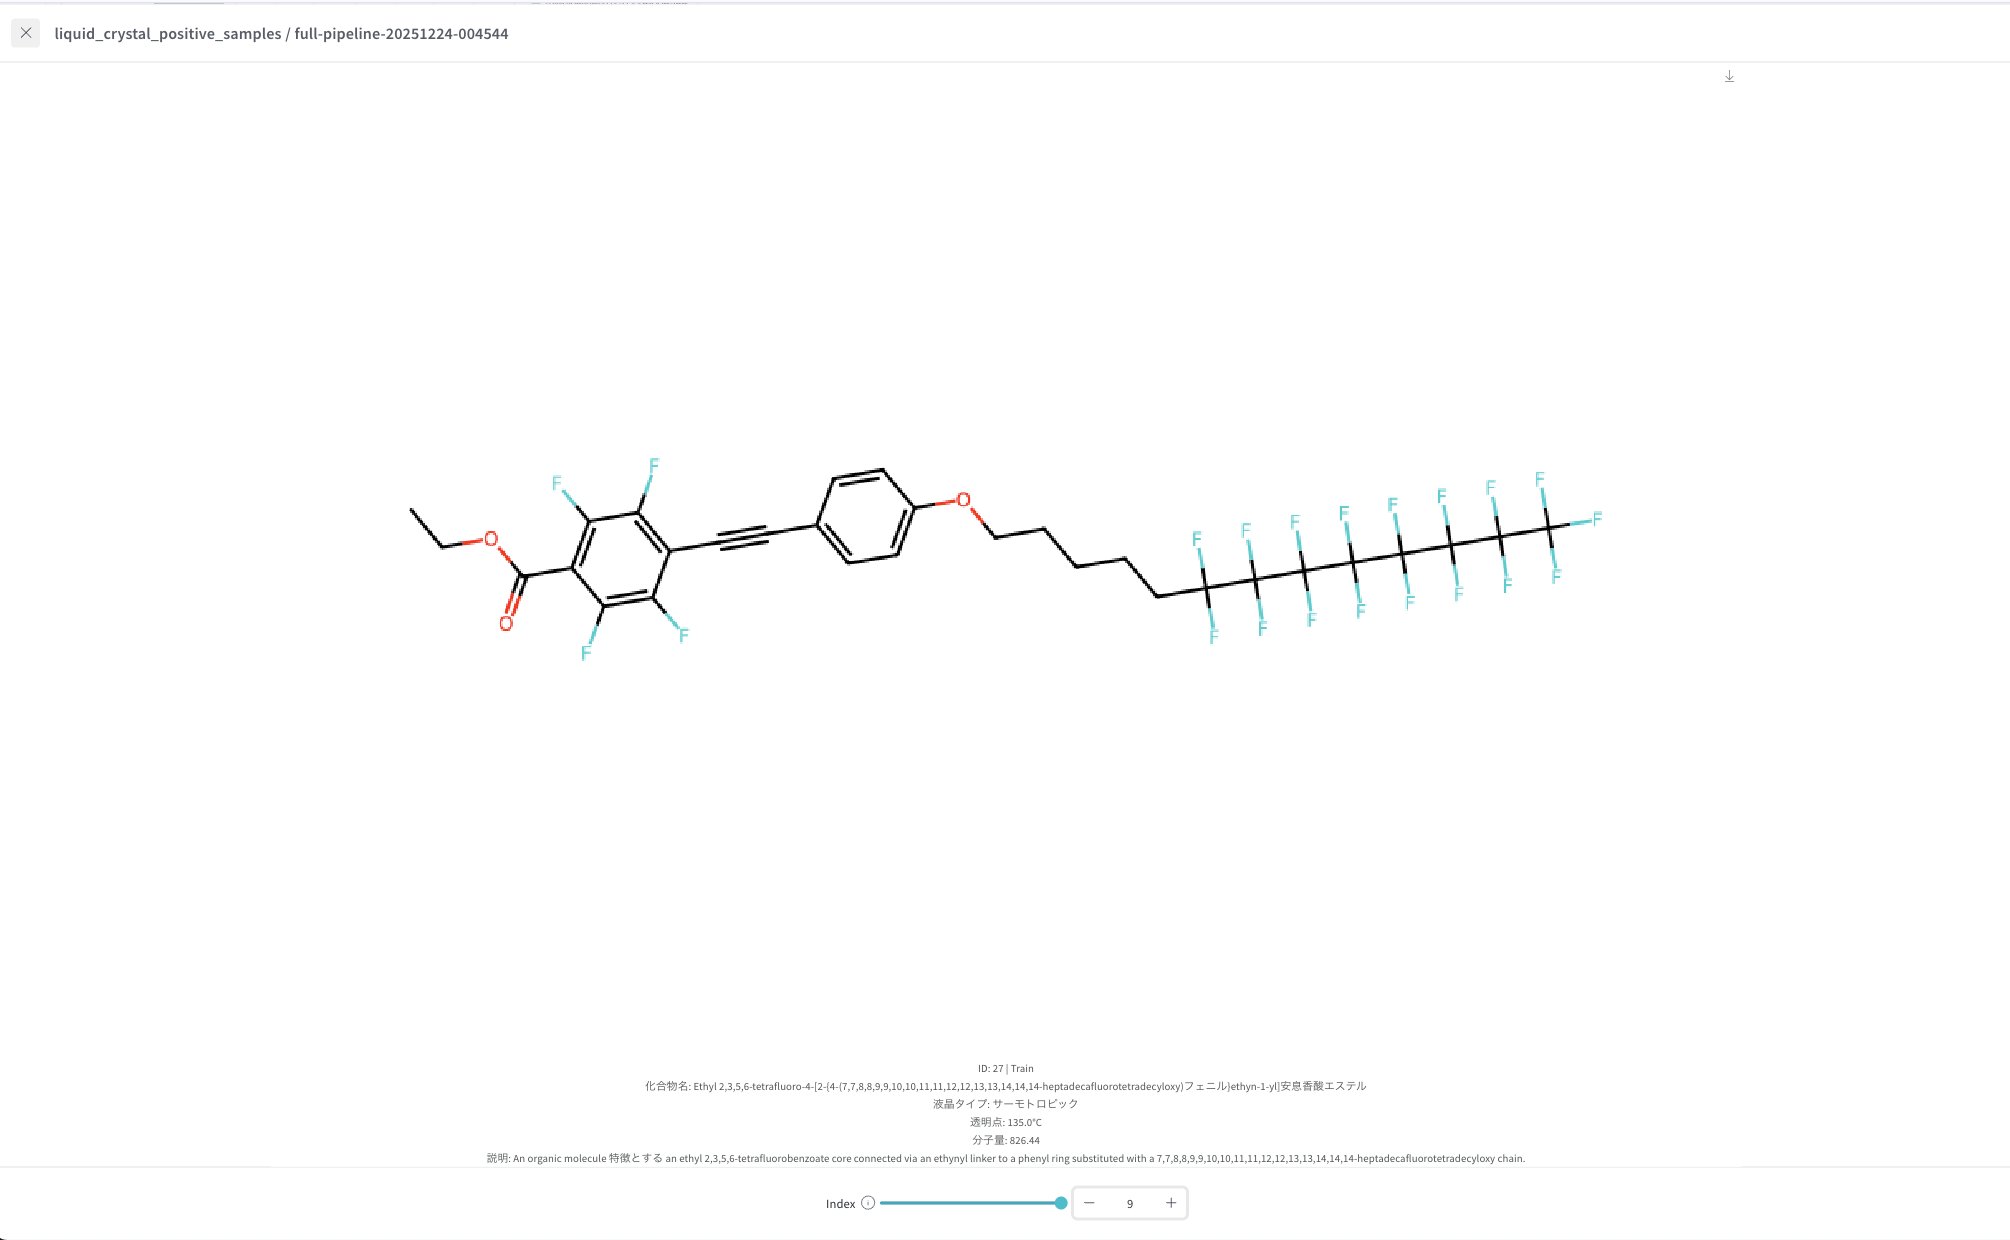

# はじめに: 各種設定
- configのところを書き換えてもらえれば、各自の目的に沿った形に変更可能

In [1]:
# ==========================
# import libraries
# ==========================
# 可視化API
import wandb
# いつもの
import os
from pathlib import Path
import json, random
from datetime import datetime
import pandas as pd
import polars as pl
import numpy as np
# Config用
from types import SimpleNamespace
# 化学ライブラリ
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit import RDLogger
# プログレスバー
from tqdm import tqdm
# Kaggle環境でのwidgetエラーを回避
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', module='tqdm')
# RDKitの警告メッセージを抑制
RDLogger.DisableLog('rdApp.*')

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

##　config設定

In [2]:
# ===============
# Config 
# ===============
config = SimpleNamespace(
    # データパス
    data_dir = Path("/kaggle/input/data-science-osaka-winter-2025"),
    
    # 基本設定
    seed = 42,
    
    # WandB設定
    wandb_entity = "hidebu",
    wandb_project = "DSOW2025_Molecule_Visualizer",
    wandb_base_url = "https://toyota.wandb.io",  # パブリックWandBの場合は削除
    wandb_secret_label = "wandb_tmc_key",
    
    # 可視化設定
    num_visualization_samples = 200, # 可視化する分子のサンプル数
    generate_html_report = True,     # HTMLレポートを生成するか
    generate_type_examples = True,   # 液晶タイプ別サンプルを生成するか
    generate_positive_samples = 10,  # 液晶性ありのサンプル数
    generate_type_samples = 5,       # 各液晶タイプのサンプル数
    
    # 分子画像設定
    molecule_image_size = (600, 400),      # 通常の分子画像サイズ
    molecule_image_size_large = (800, 600), # 詳細表示用の画像サイズ
)

In [3]:
# ==========================
# WandB認証設定（Kaggle環境用）
# ==========================
from kaggle_secrets import UserSecretsClient
os.environ["WANDB_ENTITY"] = config.wandb_entity
os.environ["WANDB_PROJECT"] = config.wandb_project
os.environ["WANDB_BASE_URL"] = config.wandb_base_url
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret(config.wandb_secret_label)

# Base group to keep runs together (timestamped)
BASE_GROUP = os.environ.get("WANDB_BASE_GROUP", "")
if not BASE_GROUP:
    BASE_GROUP = f"lc-sample-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    os.environ["WANDB_BASE_GROUP"] = BASE_GROUP

In [4]:
# ==========================
# WandB初期化
# ==========================
run = wandb.init(
    project=config.wandb_project,
    entity=config.wandb_entity,
    group=BASE_GROUP,
    job_type="data-upload-and-visualization",
    name=f"full-pipeline-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config={
        "dataset": "dsow2025dataset",
        "purpose": "液晶材料EDA - データ処理 + 可視化",
        "upload_date": datetime.now().isoformat(),
        "use_polars": True,
        "seed": config.seed,
        "visualization_samples": config.num_visualization_samples,
        "generate_html_report": config.generate_html_report,
        "generate_type_examples": config.generate_type_examples
    },
    tags=["data-preprocessing", "EDA", "liquid-crystal", "polars", "visualization"]
)

print("="*60)
print("🚀 液晶材料データパイプライン開始")
print("="*60)
print(f"WandB Run URL: {run.url}")
print(f"WandB Group: {BASE_GROUP}")
print(f"設定:")
print(f"  - 可視化サンプル数: {config.num_visualization_samples}")
print(f"  - HTMLレポート: {config.generate_html_report}")
print(f"  - タイプ別サンプル: {config.generate_type_examples}")
print()

wandb: Currently logged in as: hidebu to https://toyota.wandb.io. Use `wandb login --relogin` to force relogin
wandb: setting up run i5za5r6d
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251224_012840-i5za5r6d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run full-pipeline-20251224-012839
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer/runs/i5za5r6d


🚀 液晶材料データパイプライン開始
WandB Run URL: https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer/runs/i5za5r6d
WandB Group: lc-sample-20251224-012839
設定:
  - 可視化サンプル数: 200
  - HTMLレポート: True
  - タイプ別サンプル: True



In [5]:
# ===============
# Set seed
# ===============
def seed_everything(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything(seed=config.seed)    

# PART 1: データ読み込みと前処理

In [6]:
# ==========================
# PART 1: データ読み込みと前処理
# ==========================
print("📂 PART 1: データ読み込みと前処理")
print("-"*60)

# READ_DATA
print("データ読み込み中...")
train_df  = pl.read_csv(config.data_dir / 'train.csv')
test_df   = pl.read_csv(config.data_dir / 'test.csv')
supple_df = pl.read_csv(config.data_dir / 'supplemental.csv')

print(f"  Train: {len(train_df)} 行")
print(f"  Test: {len(test_df)} 行")
print(f"  Supplemental: {len(supple_df)} 行")

# データの結合
train_df = train_df.with_columns(pl.lit(True).alias("is_train"))
test_df  = test_df.with_columns(pl.lit(False).alias("is_train"))
# diagonal: カラムが異なっていても結合可能
df = pl.concat([train_df, test_df], how="diagonal")
print(f"  Train+Test結合後: {len(df)} 行")

# Supplementalも必要なら結合
# df = pl.concat([df, supple_df], how="diagonal")

📂 PART 1: データ読み込みと前処理
------------------------------------------------------------
データ読み込み中...
  Train: 1020 行
  Test: 1127 行
  Supplemental: 213 行
  Train+Test結合後: 2147 行


## 日本語化処理

In [7]:
# ==========================
# 日本語化処理
# ==========================
print("\n日本語化処理中...")

lc_type_ja_map = {
    'Monotropic': '単方性',
    'Thermotropic': 'サーモトロピック',
    'Lyotropic': 'リオトロピック',
    'Enantiotropic': '対方性'
}

def translate_compound_name(name: str) -> str:
    """化合物名を部分的に日本語化"""
    if name is None or pd.isna(name):
        return name
    translations = {
        'nitrophenoxy': 'ニトロフェノキシ', 'carbonyl': 'カルボニル',
        'phenyl': 'フェニル', 'propoxy': 'プロポキシ',
        'octyloxy': 'オクチルオキシ', 'benzoate': '安息香酸エステル',
        'Poly[oxy': 'ポリ[オキシ', 'decamethyl': 'デカメチル',
        'siloxane': 'シロキサン', 'Tris': 'トリス',
        'dihexyloxy': 'ジヘキシルオキシ', 'triazole': 'トリアゾール',
        'ester': 'エステル', 'methyl': 'メチル', 'ethyl': 'エチル',
        'butyl': 'ブチル', 'hexyl': 'ヘキシル'
    }
    translated = name
    for eng, jpn in translations.items():
        translated = translated.replace(eng, jpn)
    return translated

def translate_description(desc: str) -> str:
    """説明文を簡易的に日本語化"""
    if desc is None or pd.isna(desc):
        return desc
    translations = {
        'A tri-aryl ester': 'トリアリールエステル化合物',
        'comprising': 'を含む', 'central': '中心の',
        'A cyclolinear': '環状線状', 'polymer': 'ポリマー',
        'A star-shaped': '星型', 'heteroaromatic system': 'ヘテロ芳香族系',
        'featuring': '特徴とする'
    }
    translated = desc
    for eng, jpn in translations.items():
        translated = translated.replace(eng, jpn)
    return translated

# Polarsで日本語カラムを追加（プログレスバー付き）
with tqdm(total=3, desc="日本語化処理", ncols=100) as pbar:
    # compound_name_ja
    df = df.with_columns(
        pl.col("compound_name").map_elements(
            translate_compound_name, return_dtype=pl.Utf8
        ).alias("compound_name_ja")
    )
    pbar.update(1)
    
    # lc_type_ja
    df = df.with_columns(
        pl.col("lc_type").replace(lc_type_ja_map).alias("lc_type_ja")
    )
    pbar.update(1)
    
    # description_ja
    df = df.with_columns(
        pl.col("description").map_elements(
            translate_description, return_dtype=pl.Utf8
        ).alias("description_ja") if "description" in df.columns else pl.lit(None).alias("description_ja")
    )
    pbar.update(1)


日本語化処理中...


日本語化処理: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.05it/s]


## 分子記述子の計算

In [8]:
# ==========================
# 分子記述子の計算
# ==========================
print("\n分子記述子を計算中...")

def calculate_descriptors(smiles: str) -> dict:
    """分子記述子を計算"""
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    import pandas as pd
    
    default_result = {
        'molecular_weight': None, 'logp': None,
        'num_rotatable_bonds': None, 'num_h_acceptors': None,
        'num_h_donors': None, 'tpsa': None,
        'num_aromatic_rings': None, 'num_atoms': None,
        'valid_smiles': False
    }
    
    try:
        if smiles is None or smiles == '' or pd.isna(smiles):
            return default_result
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            return default_result
        
        return {
            'molecular_weight': round(Descriptors.MolWt(mol), 2),
            'logp': round(Descriptors.MolLogP(mol), 2),
            'num_rotatable_bonds': int(Descriptors.NumRotatableBonds(mol)),
            'num_h_acceptors': int(Descriptors.NumHAcceptors(mol)),
            'num_h_donors': int(Descriptors.NumHDonors(mol)),
            'tpsa': round(Descriptors.TPSA(mol), 2),
            'num_aromatic_rings': int(Descriptors.NumAromaticRings(mol)),
            'num_atoms': int(mol.GetNumAtoms()),
            'valid_smiles': True
        }
    except:
        return default_result

smiles_list = df.select("smiles_guess").to_series().to_list()
total_count = len(smiles_list)

descriptors_list = []
valid_count_running = 0

# tqdmでプログレスバー表示
for smiles in tqdm(smiles_list, desc="SMILES→記述子変換", ncols=100, unit="分子"):
    result = calculate_descriptors(smiles)
    descriptors_list.append(result)
    if result['valid_smiles']:
        valid_count_running += 1

descriptor_df = pl.DataFrame(descriptors_list)
df = pl.concat([df, descriptor_df], how="horizontal")

valid_count = df.filter(pl.col("valid_smiles") == True).height
print(f"✅ 有効なSMILES: {valid_count} / {len(df)} ({valid_count/len(df)*100:.1f}%)")


分子記述子を計算中...


SMILES→記述子変換: 100%|█████████████████████████████████████| 2147/2147 [00:02<00:00, 888.97分子/s]

✅ 有効なSMILES: 2021 / 2147 (94.1%)


# PART 2: WandBにデータをアップロード

In [9]:
# ==========================
# PART 2: WandBにデータをアップロード
# ==========================
print("\n📤 PART 2: WandBにデータをアップロード")
print("-"*60)

df_pandas = df.to_pandas()

# メインテーブル
print("データテーブルをアップロード中...")
with tqdm(total=1, desc="WandB Tableアップロード", ncols=100) as pbar:
    table = wandb.Table(dataframe=df_pandas)
    wandb.log({"liquid_crystal_data": table})
    pbar.update(1)

# Artifact保存
print("Artifactを保存中...")
with tqdm(total=3, desc="Artifact作成", ncols=100) as pbar:
    artifact = wandb.Artifact(
        name='liquid-crystal-train-data',
        type='dataset',
        description='液晶材料の学習データセット（前処理済み・日本語化済み）',
        metadata={
            'total_rows': len(df_pandas),
            'columns': list(df_pandas.columns),
            'upload_date': datetime.now().isoformat(),
            'has_japanese_translation': True,
            'has_molecular_descriptors': True,
            'processing_engine': 'polars',
            'seed': config.seed,
            'visualization_config': {
                'num_samples': config.num_visualization_samples,
                'generate_html': config.generate_html_report,
                'generate_type_examples': config.generate_type_examples
            }
        }
    )
    pbar.update(1)
    
    csv_path = "train_processed.csv"
    df.write_csv(csv_path)
    artifact.add_file(csv_path)
    pbar.update(1)
    
    artifact.add(table, "train_table")
    wandb.log_artifact(artifact)
    pbar.update(1)


📤 PART 2: WandBにデータをアップロード
------------------------------------------------------------
データテーブルをアップロード中...


WandB Tableアップロード: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]


Artifactを保存中...


Artifact作成: 100%|███████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


In [10]:
# ==========================
# サマリー統計をログ
# ==========================
# サマリー統計
print("サマリー統計を計算中...")
with tqdm(total=1, desc="統計計算", ncols=100) as pbar:
    wandb.summary['total_compounds'] = len(df_pandas)
    wandb.summary['train_compounds'] = df_pandas['is_train'].sum()
    wandb.summary['test_compounds'] = (~df_pandas['is_train']).sum()
    wandb.summary['liquid_crystal_ratio'] = df_pandas['is_liquid_crystal'].mean()
    wandb.summary['valid_smiles_count'] = valid_count
    wandb.summary['valid_smiles_ratio'] = valid_count / len(df_pandas)
    
    if 'is_thermotropic_lc' in df_pandas.columns:
        wandb.summary['thermotropic_ratio'] = df_pandas['is_thermotropic_lc'].mean()
    if 'clearing_point_celsius' in df_pandas.columns:
        wandb.summary['avg_clearing_point'] = df_pandas['clearing_point_celsius'].mean()
        wandb.summary['median_clearing_point'] = df_pandas['clearing_point_celsius'].median()
        wandb.summary['min_clearing_point'] = df_pandas['clearing_point_celsius'].min()
        wandb.summary['max_clearing_point'] = df_pandas['clearing_point_celsius'].max()
    if 'molecular_weight' in df_pandas.columns:
        valid_mw = df_pandas[df_pandas['valid_smiles'] == True]['molecular_weight']
        wandb.summary['avg_molecular_weight'] = valid_mw.mean()
        wandb.summary['median_molecular_weight'] = valid_mw.median()
    pbar.update(1)

サマリー統計を計算中...


統計計算: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.39it/s]


In [11]:
# ==========================
# 分布のヒストグラムをログ
# ==========================
print("ヒストグラムを生成中...")
histogram_tasks = []
if 'clearing_point_celsius' in df_pandas.columns and df_pandas['clearing_point_celsius'].notna().sum() > 0:
    histogram_tasks.append(("clearing_point_distribution", df_pandas['clearing_point_celsius'].dropna()))
if 'molecular_weight' in df_pandas.columns and df_pandas['molecular_weight'].notna().sum() > 0:
    histogram_tasks.append(("molecular_weight_distribution", df_pandas['molecular_weight'].dropna()))

for name, data in tqdm(histogram_tasks, desc="ヒストグラム生成", ncols=100):
    wandb.log({name: wandb.Histogram(data)})

ヒストグラムを生成中...


ヒストグラム生成: 100%|██████████████████████████████████████████████| 2/2 [00:00<00:00, 351.59it/s]


In [12]:
# ==========================
# LC typeの分布（棒グラフ）
# ==========================
print("分布グラフを生成中...")
plot_tasks = []
if 'lc_type' in df_pandas.columns:
    lc_type_counts = df_pandas['lc_type'].value_counts()
    plot_tasks.append(("lc_type_distribution", lc_type_counts, "LC Type", "液晶タイプの分布"))

if 'is_liquid_crystal' in df_pandas.columns:
    lc_status_counts = df_pandas['is_liquid_crystal'].value_counts()
    plot_tasks.append(("liquid_crystal_status", lc_status_counts, "Has LC Property", "液晶性の有無"))

if 'is_train' in df_pandas.columns:
    train_test_data = [["Train", df_pandas['is_train'].sum()], ["Test", (~df_pandas['is_train']).sum()]]
    plot_tasks.append(("train_test_distribution", train_test_data, "Dataset", "Train/Test分布"))

for plot_name, data, x_label, title in tqdm(plot_tasks, desc="分布グラフ生成", ncols=100):
    if plot_name == "train_test_distribution":
        wandb.log({
            plot_name: wandb.plot.bar(
                wandb.Table(data=data, columns=[x_label, "Count"]),
                x_label, "Count", title=title
            )
        })
    else:
        wandb.log({
            plot_name: wandb.plot.bar(
                wandb.Table(data=[[k, v] for k, v in data.items()], columns=[x_label, "Count"]),
                x_label, "Count", title=title
            )
        })

分布グラフを生成中...


分布グラフ生成: 100%|█████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]


In [13]:
# ==========================
# 散布図: 分子量 vs 透明点
# ==========================
if 'molecular_weight' in df_pandas.columns and 'clearing_point_celsius' in df_pandas.columns:
    scatter_data = df_pandas[['molecular_weight', 'clearing_point_celsius', 'lc_type']].dropna()
    if len(scatter_data) > 0:
        wandb.log({
            "mw_vs_clearing_point": wandb.plot.scatter(
                wandb.Table(data=scatter_data.values.tolist(),
                           columns=["Molecular Weight", "Clearing Point (°C)", "LC Type"]),
                "Molecular Weight", "Clearing Point (°C)", title="分子量 vs 透明点"
            )
        })

# PART 3: 分子構造の可視化

In [14]:
# ==========================
# PART 3: 分子構造の可視化
# ==========================
print("\n🧪 PART 3: 分子構造の可視化")
print("-"*60)

df_valid = df_pandas[df_pandas['valid_smiles'] == True].copy()
print(f"有効なSMILESデータ: {len(df_valid)} 行")

def generate_molecule_image(smiles, size=None):
    """SMILESから分子構造の画像を生成"""
    if size is None:
        size = config.molecule_image_size
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        img = Draw.MolToImage(mol, size=size)
        return img
    except:
        return None

# サンプル分子の可視化
print(f"\n分子構造を生成中（{config.num_visualization_samples}件）...")
num_samples = min(config.num_visualization_samples, len(df_valid))
sample_df = df_valid.head(num_samples).copy()

molecule_data = []
for idx, row in tqdm(sample_df.iterrows(), total=num_samples, desc="分子構造画像生成", ncols=100, unit="分子"):
    img = generate_molecule_image(row['smiles_guess'])
    
    if img is not None:
        molecule_data.append({
            'row_id': row['row_id'],
            'compound_name_ja': row['compound_name_ja'],
            'lc_type_ja': row['lc_type_ja'],
            'is_liquid_crystal': row['is_liquid_crystal'],
            'clearing_point_celsius': row['clearing_point_celsius'],
            'description_ja': row.get('description_ja', row.get('description', '')),
            'molecular_weight': row['molecular_weight'],
            'is_train': row['is_train'],
            'image': wandb.Image(img, caption=f"ID: {row['row_id']} - {row['compound_name_ja'][:50]}...")
        })


🧪 PART 3: 分子構造の可視化
------------------------------------------------------------
有効なSMILESデータ: 2021 行

分子構造を生成中（200件）...


分子構造画像生成: 100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 30.96分子/s]


In [15]:
# WandB Tableに画像を追加
print("WandB Tableを作成中...")
with tqdm(total=1, desc="分子構造Tableアップロード", ncols=100) as pbar:
    columns = ['row_id', 'compound_name_ja', 'lc_type_ja', 'is_liquid_crystal', 
               'clearing_point_celsius', 'molecular_weight', 'is_train', 'description_ja', 'image']
    
    table_data = [[d[col] for col in columns] for d in molecule_data]
    molecule_table = wandb.Table(columns=columns, data=table_data)
    wandb.log({"molecule_structures": molecule_table})
    pbar.update(1)

# 液晶性ありのサンプル
print(f"\n液晶性ありのサンプルを生成中（{config.generate_positive_samples}件）...")
lc_positive = df_valid[df_valid['is_liquid_crystal'] == True].head(config.generate_positive_samples)
lc_images = []

for idx, row in tqdm(lc_positive.iterrows(), total=len(lc_positive), desc="液晶性ありサンプル", ncols=100):
    img = generate_molecule_image(row['smiles_guess'], size=config.molecule_image_size_large)
    if img is not None:
        caption = f"""ID: {row['row_id']} | {'Train' if row['is_train'] else 'Test'}
化合物名: {row['compound_name_ja']}
液晶タイプ: {row['lc_type_ja']}
透明点: {row['clearing_point_celsius']}°C
分子量: {row['molecular_weight']}
説明: {row.get('description_ja', row.get('description', ''))}"""
        lc_images.append(wandb.Image(img, caption=caption))

if lc_images:
    wandb.log({"liquid_crystal_positive_samples": lc_images})

# 液晶タイプ別の代表例
if config.generate_type_examples:
    print(f"\n液晶タイプ別の代表例を作成中（各タイプ{config.generate_type_samples}件）...")
    lc_types = df_valid['lc_type'].dropna().unique()
    
    for lc_type in tqdm(lc_types, desc="液晶タイプ別サンプル", ncols=100):
        type_samples = df_valid[df_valid['lc_type'] == lc_type].head(config.generate_type_samples)
        type_images = []
        
        for idx, row in type_samples.iterrows():
            img = generate_molecule_image(row['smiles_guess'])
            if img is not None:
                caption = f"{row['compound_name_ja']}\n透明点: {row['clearing_point_celsius']}°C"
                type_images.append(wandb.Image(img, caption=caption))
        
        if type_images:
            wandb.log({f"lc_type_{lc_type}_examples": type_images})

WandB Tableを作成中...


分子構造Tableアップロード: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]



液晶性ありのサンプルを生成中（10件）...


液晶性ありサンプル: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]



液晶タイプ別の代表例を作成中（各タイプ5件）...


液晶タイプ別サンプル: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]


In [16]:
# HTMLレポート
if config.generate_html_report:
    print("\nHTMLレポートを生成中...")
    
    html_content = f"""
    <html>
    <head>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: 'Segoe UI', Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .header {{ background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                       color: white; padding: 30px; border-radius: 10px; margin-bottom: 30px; }}
            .stats {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); 
                     gap: 20px; margin: 20px 0; }}
            .stat-card {{ background: white; padding: 20px; border-radius: 8px; 
                         box-shadow: 0 2px 4px rgba(0,0,0,0.1); text-align: center; }}
            .stat-value {{ font-size: 32px; font-weight: bold; color: #667eea; }}
            .stat-label {{ color: #666; margin-top: 10px; }}
            .molecule-card {{ background: white; margin: 20px 0; padding: 25px; 
                            border-radius: 10px; box-shadow: 0 2px 8px rgba(0,0,0,0.1); }}
            .info-box {{ background: #f8f9fa; padding: 15px; margin: 15px 0; 
                        border-radius: 5px; border-left: 4px solid #667eea; }}
            .highlight {{ background: #667eea; color: white; padding: 5px 12px; 
                         border-radius: 20px; display: inline-block; margin: 5px; font-size: 14px; }}
            .train {{ background: #28a745; }}
            .test {{ background: #ffc107; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>🔬 液晶材料 分子構造可視化レポート</h1>
            <p style="font-size: 18px;">生成日時: {datetime.now().strftime('%Y年%m月%d日 %H:%M:%S')}</p>
            <p>Group: {BASE_GROUP}</p>
        </div>
        
        <div class="stats">
            <div class="stat-card">
                <div class="stat-value">{len(df_pandas)}</div>
                <div class="stat-label">総化合物数</div>
            </div>
            <div class="stat-card">
                <div class="stat-value">{df_pandas['is_train'].sum()}</div>
                <div class="stat-label">Trainデータ</div>
            </div>
            <div class="stat-card">
                <div class="stat-value">{(~df_pandas['is_train']).sum()}</div>
                <div class="stat-label">Testデータ</div>
            </div>
            <div class="stat-card">
                <div class="stat-value">{valid_count}</div>
                <div class="stat-label">有効なSMILES</div>
            </div>
            <div class="stat-card">
                <div class="stat-value">{df_pandas['is_liquid_crystal'].sum()}</div>
                <div class="stat-label">液晶性あり</div>
            </div>
            <div class="stat-card">
                <div class="stat-value">{df_pandas['clearing_point_celsius'].mean():.1f}°C</div>
                <div class="stat-label">平均透明点</div>
            </div>
        </div>
        
        <h2>📊 可視化サンプル（{len(molecule_data)}件）</h2>
    """
    
    for data in molecule_data[:20]:
        train_test_class = "train" if data['is_train'] else "test"
        train_test_label = "Train" if data['is_train'] else "Test"
        
        html_content += f"""
        <div class="molecule-card">
            <h3>ID: {data['row_id']} - {data['compound_name_ja']}</h3>
            <div class="info-box">
                <span class="highlight {train_test_class}">{train_test_label}</span>
                <span class="highlight">液晶性: {'あり' if data['is_liquid_crystal'] else 'なし'}</span>
                <span class="highlight">透明点: {data['clearing_point_celsius']}°C</span>
                <span class="highlight">分子量: {data['molecular_weight']}</span>
                <span class="highlight">タイプ: {data['lc_type_ja']}</span>
            </div>
            <p style="color: #555; line-height: 1.6;">{data['description_ja']}</p>
        </div>
        """
    
    html_content += "</body></html>"
    wandb.log({"molecule_report": wandb.Html(html_content)})


HTMLレポートを生成中...


In [17]:
# ==========================
# 完了メッセージ
# ==========================
print("\n" + "="*60)
print("✅ 全処理が完了しました！")
print("="*60)
print(f"WandB Run URL: {run.url}")
print(f"\n📊 統計情報:")
print(f"  総データ数: {len(df_pandas)}")
print(f"  Train: {df_pandas['is_train'].sum()} / Test: {(~df_pandas['is_train']).sum()}")
print(f"  液晶性あり: {df_pandas['is_liquid_crystal'].sum()} ({df_pandas['is_liquid_crystal'].mean()*100:.1f}%)")
print(f"  有効なSMILES: {valid_count} ({valid_count/len(df_pandas)*100:.1f}%)")
if 'clearing_point_celsius' in df_pandas.columns:
    print(f"  平均透明点: {df_pandas['clearing_point_celsius'].mean():.1f}°C")
print(f"\n📊 アップロードされた内容:")
print(f"  ✓ データテーブル: liquid_crystal_data")
print(f"  ✓ 分子構造テーブル: molecule_structures ({len(molecule_data)}件)")
print(f"  ✓ 液晶性ありサンプル: {len(lc_images)}件")
if config.generate_type_examples:
    print(f"  ✓ 液晶タイプ別サンプル（各{config.generate_type_samples}件）")
if config.generate_html_report:
    print(f"  ✓ HTMLレポート")
print(f"  ✓ 各種統計グラフ")
print(f"\n💡 次のステップ:")
print(f"  1. WandB UIでデータを確認: {run.url}")
print(f"  2. Streamlitダッシュボードを起動:")
print(f"     streamlit run wandb_dashboard_app.py")
print("="*60)

wandb.finish()

wandb: uploading artifact run-i5za5r6d-molecule_structures; uploading media/images/lc_type_No-LC_examples_11_1a3f736e9f6391ca6b86.png; updating run metadata



✅ 全処理が完了しました！
WandB Run URL: https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer/runs/i5za5r6d

📊 統計情報:
  総データ数: 2147
  Train: 1020 / Test: 1127
  液晶性あり: 425 (41.7%)
  有効なSMILES: 2021 (94.1%)
  平均透明点: 151.0°C

📊 アップロードされた内容:
  ✓ データテーブル: liquid_crystal_data
  ✓ 分子構造テーブル: molecule_structures (200件)
  ✓ 液晶性ありサンプル: 10件
  ✓ 液晶タイプ別サンプル（各5件）
  ✓ HTMLレポート
  ✓ 各種統計グラフ

💡 次のステップ:
  1. WandB UIでデータを確認: https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer/runs/i5za5r6d
  2. Streamlitダッシュボードを起動:
     streamlit run wandb_dashboard_app.py


wandb: 
wandb: Run summary:
wandb:      avg_clearing_point 151.03128
wandb:    avg_molecular_weight 519.59852
wandb:    liquid_crystal_ratio 0.41667
wandb:      max_clearing_point 420
wandb:   median_clearing_point 147.4
wandb: median_molecular_weight 418.44
wandb:      min_clearing_point -4.5
wandb:          test_compounds 1127
wandb:      thermotropic_ratio 0.3049
wandb:         total_compounds 2147
wandb:                      +3 ...
wandb: 
wandb: 🚀 View run full-pipeline-20251224-012839 at: https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer/runs/i5za5r6d
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025_Molecule_Visualizer
wandb: Synced 5 W&B file(s), 37 media file(s), 212 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251224_012840-i5za5r6d/logs
